In [1]:
import sympy
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, TensorSymmetry
from einsteinpy.symbolic import RicciTensor, MetricTensor

sympy.init_printing()

Compute the Einstein tensor.

In [2]:
syms = sympy.symbols("r psi theta phi")
r, psi, theta, phi = syms
f = sympy.Function('f')(r)  # metric ansatz
L = sympy.symbols("L")  # AdS length scale
cap_phi = sympy.Function('Phi')(r)  # defines gauge field

In [3]:
list2d = [[0 for i in range(4)] for i in range(4)]
list2d[0][0] = 1/f
list2d[1][1] = list2d[2][2] = list2d[3][3] = r**2/4
list2d[1][3] = list2d[3][1] = r**2 / 4 * sympy.cos(theta)
sch = MetricTensor(list2d, syms)
sch.tensor()

⎡ 1                            ⎤
⎢────      0      0       0    ⎥
⎢f(r)                          ⎥
⎢                              ⎥
⎢          2           2       ⎥
⎢         r           r ⋅cos(θ)⎥
⎢ 0       ──      0   ─────────⎥
⎢         4               4    ⎥
⎢                              ⎥
⎢                  2           ⎥
⎢                 r            ⎥
⎢ 0        0      ──      0    ⎥
⎢                 4            ⎥
⎢                              ⎥
⎢       2                 2    ⎥
⎢      r ⋅cos(θ)         r     ⎥
⎢ 0    ─────────  0      ──    ⎥
⎣          4             4     ⎦

In [4]:
Ric = RicciTensor.from_metric(sch)
Ric.tensor()

⎡   d                                                                         
⎢-3⋅──(f(r))                                                                  
⎢   dr                                                                        
⎢────────────                  0                              0               
⎢  2⋅r⋅f(r)                                                                   
⎢                                                                             
⎢                       d                                                   ⎛ 
⎢                     r⋅──(f(r))                                            ⎜-
⎢                       dr         f(r)   1                                 ⎝ 
⎢     0             - ────────── - ──── + ─                   0             ──
⎢                         8         2     2                                   
⎢                                                                             
⎢                                                   

In [5]:
metric_array = sympy.MutableDenseNDimArray(list2d)
einstein_tensor = sympy.MutableDenseNDimArray(Ric.tensor()) + 3 / L ** 2 * metric_array
einstein_tensor

⎡    d                                                                        
⎢  3⋅──(f(r))                                                                 
⎢    dr            3                                                          
⎢- ────────── + ───────                         0                             
⎢   2⋅r⋅f(r)     2                                                            
⎢               L ⋅f(r)                                                       
⎢                                                                             
⎢                                     d                                       
⎢                                   r⋅──(f(r))                 2              
⎢                                     dr         f(r)   1   3⋅r               
⎢          0                      - ────────── - ──── + ─ + ────              
⎢                                       8         2     2      2              
⎢                                                   

In [6]:
for i in range(4):
    for j in range(4):
        einstein_tensor[i, j] = einstein_tensor[i, j].simplify()
einstein_tensor

⎡    d                                                                        
⎢  3⋅──(f(r))                                                                 
⎢    dr            3                                                          
⎢- ────────── + ───────                        0                              
⎢   2⋅r⋅f(r)     2                                                            
⎢               L ⋅f(r)                                                       
⎢                                                                             
⎢                             2 ⎛    d                    ⎞      2            
⎢                            L ⋅⎜- r⋅──(f(r)) - 4⋅f(r) + 4⎟ + 6⋅r             
⎢                               ⎝    dr                   ⎠                   
⎢          0                 ─────────────────────────────────────            
⎢                                                2                            
⎢                                             8⋅L   

Compute the right-hand side of the Einstein equation.

In [7]:

A_1 = L / 2 * cap_phi * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * cap_phi * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * cap_phi * sympy.Array([0, 1, 0, sympy.cos(theta)])

In [8]:
A_1, A_2, A_3

⎛⎡      -L⋅Φ(r)⋅sin(ψ)   L⋅Φ(r)⋅sin(θ)⋅cos(ψ)⎤  ⎡      L⋅Φ(r)⋅cos(ψ)  L⋅Φ(r)⋅s
⎜⎢0  0  ───────────────  ────────────────────⎥, ⎢0  0  ─────────────  ────────
⎝⎣             2                  2          ⎦  ⎣            2                

in(ψ)⋅sin(θ)⎤  ⎡   L⋅Φ(r)     L⋅Φ(r)⋅cos(θ)⎤⎞
────────────⎥, ⎢0  ──────  0  ─────────────⎥⎟
 2          ⎦  ⎣     2              2      ⎦⎠

In [9]:
x = [r, psi, theta, phi]
def em_field_strength(A):
    """Compute EM field strength from the vector potential."""    
    F = sympy.MutableDenseNDimArray.zeros(4, 4)
    for i in range(4):
        for j in range(4):
            F[i, j] = sympy.diff(A[j], x[i]) - sympy.diff(A[i], x[j])
    return F

In [10]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

In [11]:
FF = sympy.tensorproduct(F_1, F_1) + sympy.tensorproduct(F_2, F_2) + sympy.tensorproduct(F_3, F_3)

Wrap into a tensor object with appropriate indices.

In [12]:
Lorentz = TensorIndexType('Lorentz', dummy_name='L')
mu, nu, rho, sigma = tensor_indices('mu, nu, rho, sigma', Lorentz)
T_tensor = TensorHead('T', [Lorentz, Lorentz, Lorentz, Lorentz])

In [13]:
T_tensor(-mu, -nu, -rho, sigma)

In [14]:
repl = {T_tensor(-mu, -nu, -rho, -sigma): FF, Lorentz: list2d}

In [15]:
T_contracted_1 = T_tensor(-mu, -nu, -rho, nu).replace_with_arrays(repl)
T_contracted_1

⎡                                                                  ⎛          
⎢                                                                  ⎜   2    2 
⎢                                          2                 2     ⎜  L ⋅sin (
⎢                      2    2    ⎛d       ⎞      2 ⎛d       ⎞      ⎜          
⎢                   2⋅L ⋅cos (θ)⋅⎜──(Φ(r))⎟     L ⋅⎜──(Φ(r))⎟    4⋅⎜- ────────
⎢                                ⎝dr      ⎠        ⎝dr      ⎠      ⎝          
⎢                 - ──────────────────────── + ─────────────── - ─────────────
⎢                        2    2       2         2    2       2                
⎢                       r ⋅cos (θ) - r         r ⋅cos (θ) - r                 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [16]:
for i in range(4):
    for j in range(4):
        T_contracted_1[i, j] = T_contracted_1[i, j].simplify()
T_contracted_1

⎡                2                                                            
⎢    2 ⎛d       ⎞                                                             
⎢-3⋅L ⋅⎜──(Φ(r))⎟                                                             
⎢      ⎝dr      ⎠                                                             
⎢──────────────────                       0                                   
⎢         2                                                                   
⎢        r                                                                    
⎢                                                                             
⎢                           ⎛                  2          ⎞                   
⎢                         2 ⎜ 2      ⎛d       ⎞       2   ⎟                   
⎢                       -L ⋅⎜r ⋅f(r)⋅⎜──(Φ(r))⎟  + 8⋅Φ (r)⎟                   
⎢                           ⎝        ⎝dr      ⎠           ⎠                   
⎢        0              ────────────────────────────

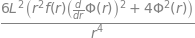

In [17]:
T_contracted_2 = T_tensor(-mu, -nu, mu, nu).replace_with_arrays(repl)
T_contracted_2 = T_contracted_2.simplify()
T_contracted_2

Compute the energy-momentum tensor.

In [18]:
energy_momentum = 2 * (T_contracted_1 - metric_array / 4 * T_contracted_2)
for i in range(4):
    for j in range(4):
        energy_momentum[i, j] = energy_momentum[i, j].simplify()

In [19]:
energy_momentum

⎡   ⎛                      2           ⎞                                      
⎢ 2 ⎜     2      ⎛d       ⎞        2   ⎟                                      
⎢L ⋅⎜- 9⋅r ⋅f(r)⋅⎜──(Φ(r))⎟  - 12⋅Φ (r)⎟                                      
⎢   ⎝            ⎝dr      ⎠            ⎠                                      
⎢───────────────────────────────────────                        0             
⎢                 4                                                           
⎢                r ⋅f(r)                                                      
⎢                                                                             
⎢                                               ⎛                      2      
⎢                                             2 ⎜     2      ⎛d       ⎞       
⎢                                            L ⋅⎜- 5⋅r ⋅f(r)⋅⎜──(Φ(r))⎟  - 28⋅
⎢                                               ⎝            ⎝dr      ⎠       
⎢                   0                        ───────

Evaluate solution.

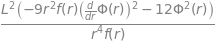

In [20]:
energy_momentum[0, 0]

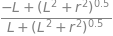

In [21]:
phi = ((L ** 2 + r ** 2) ** (1/2) - L) / ((L ** 2 + r ** 2) ** (1/2) + L) 
phi

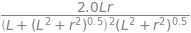

In [22]:
dphidr = sympy.diff(phi, r).simplify()
dphidr

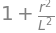

In [23]:
f = 1 + r ** 2 / L ** 2
f

In [24]:
T_00 = (L ** 2 * (-9 * r ** 2 * f * dphidr ** 2 - 12 * phi ** 2) / (r ** 4 * f)).simplify()

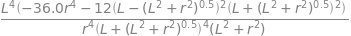

In [25]:
T_00